## [Computational Social Science] Project 5: Natural Language Processing

#### Hyemin Park

## PART 0: Base

In [ ]:
###' ################################################################################
###'
###' IMPORT LIBRARIES
###'
###'

### pandas and numpy
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt

### punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
from spellchecker import SpellChecker
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import en_core_web_sm
nlp = en_core_web_sm.load()
import scattertext as st

### textblob
from textblob import TextBlob

### countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE

### tqdm
from tqdm import tqdm

### gensim
import gensim
from gensim import models

### PCA
import random
from adjustText import adjust_text

### plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### kMeans and silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

### ignore warnings
import warnings
warnings.filterwarnings('ignore')

###time
from datetime import datetime

In [ ]:
###' ################################################################################
###'
###' Data Load 
###'
###'

### data load
#congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
congress_tweets = pd.read_csv("C:/Users/OWNER/data/116th Congressional Tweets and Demographics.csv")


### confirm generated data
congress_tweets.head(n=5)

## PART 1: Text Processing

In [ ]:
###' ################################################################################
###'
###' Data Generation
###'
###'

### create age column
congress_tweets['date'] = congress_tweets['datetime'].str[:10]
congress_tweets['birthday'] = pd.to_datetime(congress_tweets['birthday'])
congress_tweets['age'] = pd.to_numeric(congress_tweets['date'].str[:4]) - congress_tweets['birthday'].dt.year


### confirm generated data
congress_tweets.head(n=5)

In [ ]:
###' ################################################################################
###'
###' Sellect Data
###'
###'

### select columns
congress_tweets_sel = congress_tweets[['tweet_id','party','position','gender','state','district_number','age','text']]
tweets = congress_tweets_sel.dropna(subset = ['text'])


### sample
tweets_party = pd.concat([tweets[tweets['party'] == 'Republican'].sample(3000, random_state = 224),
                          tweets[tweets['party'] == 'Democrat'].sample(3000, random_state = 224),
                          tweets[tweets['party'] == 'Independent'].sample(3000, random_state = 224)]).reset_index(drop = True)

###' ################################################################################
###'
###' Spell check for Random Sampled Text
###'
###'

### load spell checker
spell = SpellChecker()

### text spell check
tweets_party['text_spell'] = tweets_party['text'].map(lambda x: spell.correction(x))

### confirm generated data
tweets_party.head(n=10)

In [ ]:
###' ################################################################################
###'
###' Function for Deleteing Punctuations and StopWords
###'
###'

### define fuction
def rem_punc_stop(text):
    
    # when text is None
    if text is None:  
        return None
    
    # add more stop words
    stop_words = STOP_WORDS 
    nlp.Defaults.stop_words |= {"monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday",
                    "january", "february", "march", "april", "may", "june", "july", "august", "september", 
                    "october", "november", "december", "time", "today", "yesterday", "tomorrow", 
                    "day", "week", "month", "year","amp","RT","QT"}
    
    punc = set(punctuation)
    
    
    # remove the punctuation
    punc_free = "".join([ch for ch in text if ch not in punc])                                                               

    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
    
    # lemmatize
    text_lemma = " ".join([word.lemma_ for word in doc])
    
    # extract words from processed text 
    spacy_words = text_lemma.split()
    spacy_words_1 = [word for word in spacy_words if not word.startswith("@")]
    spacy_words_2 = [word for word in spacy_words_1 if not word.startswith("http")]
    
    
    # filter out words 
    no_stop = [word for word in spacy_words_2 if word not in stop_words]
    
    # return
    return no_stop

In [ ]:
###' ################################################################################
###'
###' Apply the Function and Tokenize Text Column
###'
###'

### sample from the whole dataset
tweets_party['tokens'] = tweets_party['text'].map(lambda x: rem_punc_stop(x))

tweets_party['tokens']

## PART 2. Word Features

In [ ]:
###' ################################################################################
###'
###' GENERATE TEXT FEATURES
###' e.g. text_len, word count, polarity, subjectivity
###'
###'


# text_len & count
tweets_party['text_len'] = tweets_party['text'].dropna().apply(len)
tweets_party['word_count'] = tweets_party['text'].dropna().apply(lambda x: len(str(x).split()))


# join token
tweets_party['tokens_join'] = tweets_party['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else "")


# polarity & subjectivity
tweets_party['polarity'] = tweets_party['tokens_join'].map(lambda text: TextBlob(text).sentiment.polarity)
tweets_party['subjectivity'] = tweets_party['tokens_join'].map(lambda text: TextBlob(text).sentiment.subjectivity)


### confirm generated data
tweets_party.head(n=5)

In [ ]:
###' ################################################################################
###'
###' VISUALIZATION TEXT FEATURES
###' by. party
###'
###'

### 1. compare text len
sns.displot(tweets_party,    
            x="text_len",  
            hue = "gender",
            stat = "probability",
            common_norm = False, 
            col = "party",
            bins = 20)

# show graph
plt.tight_layout()
plt.show()

In [ ]:
### 2. compare word count
sns.displot(tweets_party,    
            x="word_count",  
            hue = "gender", 
            stat = "probability",
            common_norm = False, 
            col = "party",
            bins = 20)

# show graph
plt.tight_layout()
plt.show()

In [ ]:
### 3. compare polarity
sns.displot(tweets_party,    
            x="polarity",  
            hue = "gender", 
            stat = "probability",
            common_norm = False, 
            col = "party",
            bins = 20)

# show graph
plt.tight_layout()
plt.show()

In [ ]:
### 4. compare subjectivity
sns.displot(tweets_party,    
            x="subjectivity",  
            hue = "gender", 
            stat = "probability",
            common_norm = False,
            col = "party",
            bins = 20)

# show graph
plt.tight_layout()
plt.show()

In [ ]:
### 5. compare scatter plot of polarity and subjectivity

sns.relplot(data = tweets_party,
            x="polarity",
            y="subjectivity",
            hue = "gender",
            col='party',
            kind = "scatter")

# show graph
plt.tight_layout()
plt.show()

In [ ]:
###' ################################################################################
###'
###' VISUALIZATION TEXT FEATURES
###' by. position
###'
###'

### 1. compare text len
sns.displot(tweets_party,    
            x="text_len",  
            hue = "gender",
            stat = "probability",
            common_norm = False, 
            col = "position",
            bins = 20)

# show graph
plt.tight_layout()
plt.show()

In [ ]:
### 2. compare word count
sns.displot(tweets_party,    
            x="word_count",  
            hue = "gender",
            stat = "probability",
            common_norm = False, 
            col = "position",
            bins = 20)

# show graph
plt.tight_layout()
plt.show()

In [ ]:
### 3. compare polarity
sns.displot(tweets_party,    
            x="polarity",  
            hue = "gender",
            stat = "probability",
            common_norm = False, 
            col = "position",
            bins = 20)

# show graph
plt.tight_layout()
plt.show()

In [ ]:
### 4. compare subjectivity
sns.displot(tweets_party,    
            x="subjectivity",  
            hue = "gender",
            stat = "probability",
            common_norm = False, 
            col = "position",
            bins = 20)

# show graph
plt.tight_layout()
plt.show()

In [ ]:
### 5. compare scatter plot of polarity and subjectivity
sns.relplot(data = tweets_party,
            x="polarity",
            y="subjectivity",
            hue = "gender",
            col='position',
            kind = "scatter")

# show graph
plt.tight_layout()
plt.show()

### PART 3: Text Explore

### 1. Word Clouds

In [ ]:
###' ################################################################################
###'
###' VISUALIZATION : Word Cloud
###' by. party
###'
###'

### 0. Sample from Whole data

# apply function to text object
TO_text = ' '.join(tweets_party['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else ""))

# create WordCloud visualization using the "text" object 
TO_wordcloud = WordCloud(background_color = "white",
                      random_state=41).generate(TO_text)          

# plot 
plt.imshow(TO_wordcloud,
           interpolation = 'bilinear')
plt.axis('off')                       
plt.show()                            

In [ ]:
### 1. REPUBLIC

# apply function to text object
RE_text = ' '.join(tweets_party[tweets_party['party'] == 'Republican']['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else ""))

# create WordCloud visualization using the "text" object 
RE_wordcloud = WordCloud(background_color = "white",
                      random_state=41              
                      ).generate(RE_text)          

# plot 
plt.imshow(RE_wordcloud,
           interpolation = 'bilinear')
plt.axis('off')                       
plt.show()   

In [ ]:
### 2. DEMOCRAT

# apply function to text object
DE_text = ' '.join(tweets_party[tweets_party['party'] == 'Democrat']['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else ""))

# create WordCloud visualization using the "text" object 
DE_wordcloud = WordCloud(background_color = "white",
                      random_state=41              
                      ).generate(DE_text)         

# plot 
plt.imshow(DE_wordcloud,                
           interpolation = 'bilinear') 
plt.axis('off')                        
plt.show()                             

In [ ]:
### 3. INDEPENDENT

# apply function to text object
IN_text = ' '.join(tweets_party[tweets_party['party'] == 'Independent']['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else ""))

# create WordCloud visualization using the "text" object 
IN_wordcloud = WordCloud(background_color = "white",
                      random_state=41              
                      ).generate(IN_text)          

# plot 
plt.imshow(IN_wordcloud,               
           interpolation = 'bilinear') 
plt.axis('off')                        
plt.show()                             

In [ ]:
###' ################################################################################
###'
###' VISUALIZATION : Word Cloud
###' by. position
###'
###'

### 1. REPRESENTITIVE

# apply function to text object
REP_text = ' '.join(tweets_party[tweets_party['position'] == 'Rep']['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else ""))

# create WordCloud visualization using the "text" object 
REP_wordcloud = WordCloud(background_color = "white",
                      random_state=41              
                      ).generate(REP_text)         

# plot 
plt.imshow(REP_wordcloud,             
           interpolation = 'bilinear')
plt.axis('off')                       
plt.show()                            

In [ ]:
### 2. SENATOR

# apply function to text object
SEN_text = ' '.join(tweets_party[tweets_party['position'] == 'Sen']['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else ""))

# create WordCloud visualization using the "text" object 
SEN_wordcloud = WordCloud(background_color = "white",
                      random_state=41              
                      ).generate(SEN_text)         

# plot 
plt.imshow(SEN_wordcloud,              
           interpolation = 'bilinear') 
plt.axis('off')                        
plt.show()                             

### 2. Scatter Text

In [ ]:
###' ################################################################################
###'
###' VISUALIZATION : SCATTER TEXT
###' by. party
###'
###'

tweets_party_part = tweets_party[tweets_party['party'] != 'Independent']

### create measure of subjectivity
corpus = st.CorpusFromPandas(tweets_party_part,
                             category_col='party',
                             text_col='tokens_join',
                             nlp=nlp).build()
### create html document
html = st.produce_scattertext_explorer(corpus,
                                       category='Republican',
                                       category_name='Republican',
                                       not_category_name='Democrat',
                                       width_in_pixels=1000,
                                       minimum_term_frequency=5
                                       #metadata=congress_tweets_part
                                      )


### save as html
open("Project5_ScatterText_party.html", 'wb').write(html.encode('utf-8'))

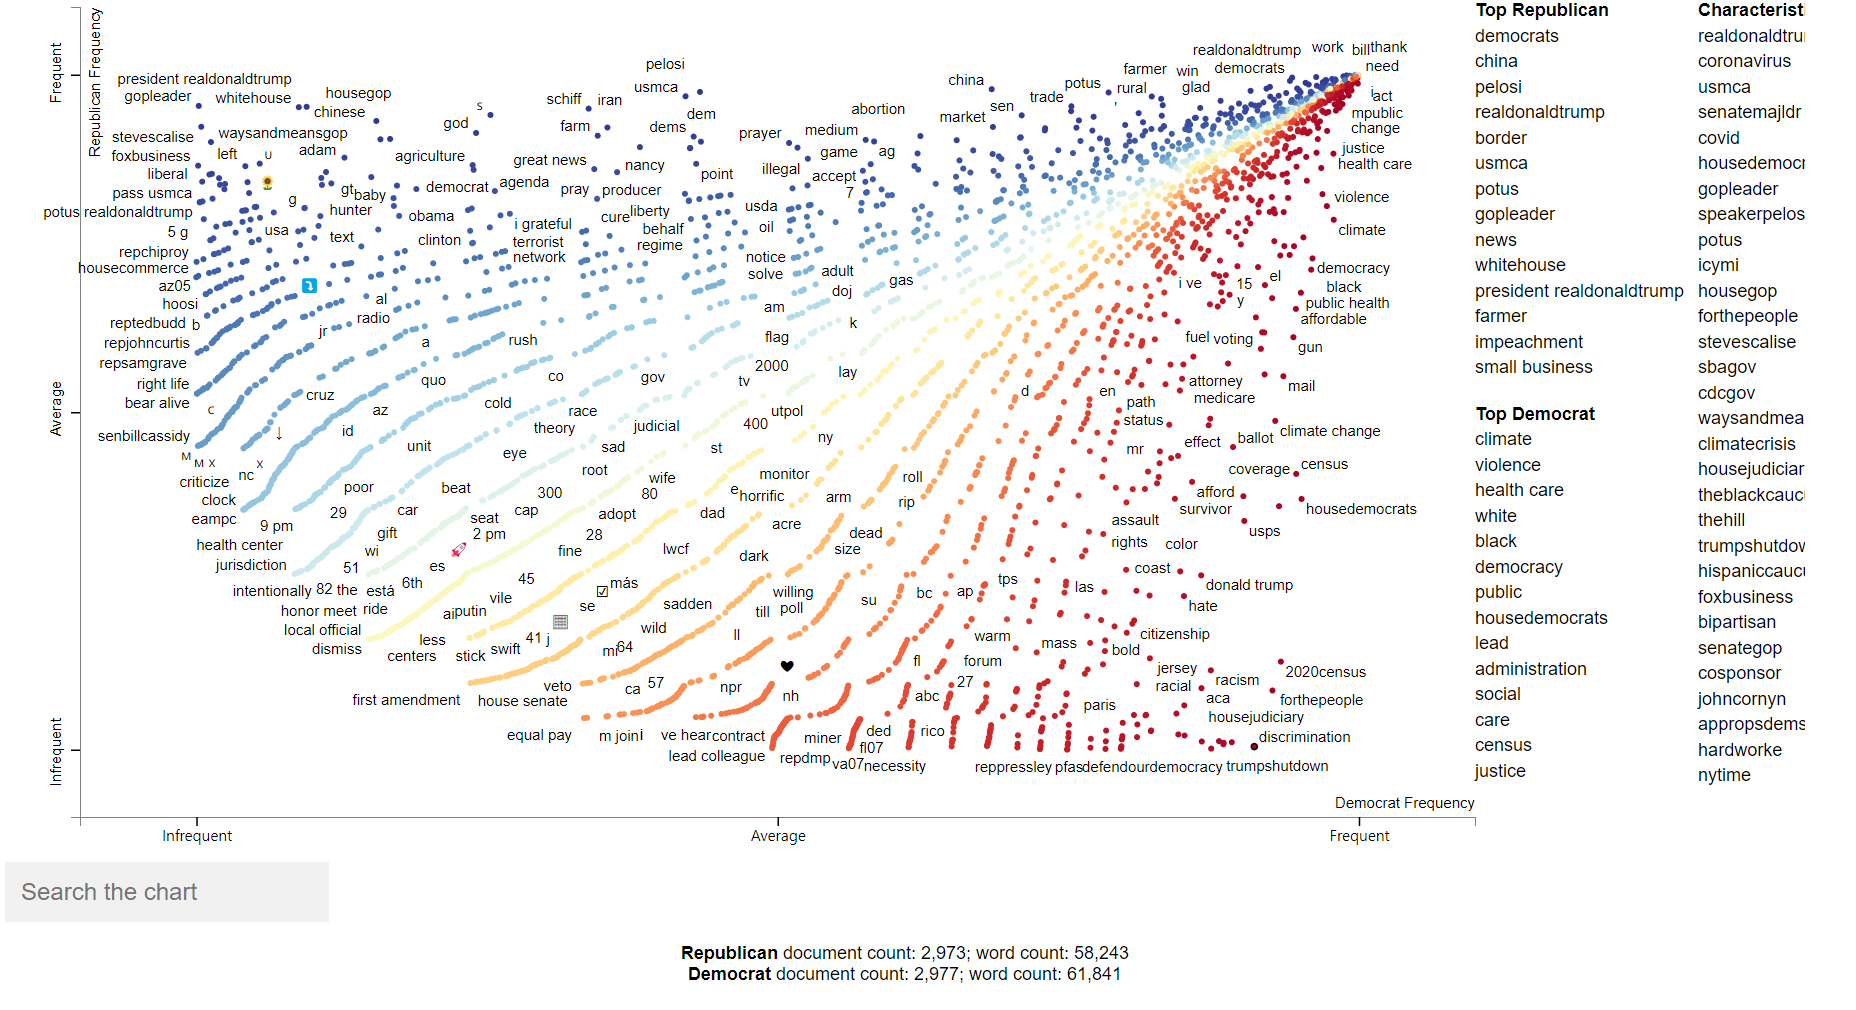

In [ ]:
###' ################################################################################
###'
###' VISUALIZATION : SCATTER TEXT
###' by. position
###'
###'


### create measure of subjectivity
corpus = st.CorpusFromPandas(tweets_party,
                             category_col='position',
                             text_col='tokens_join',
                             nlp=nlp).build()
### create html document
html = st.produce_scattertext_explorer(corpus,
                                       category='Rep',
                                       category_name='Rep',
                                       not_category_name='Sen',
                                       width_in_pixels=1000,
                                       minimum_term_frequency=5
                                       #metadata=congress_tweets_part
                                      )


### save as html
open("Project5_ScatterText_position.html", 'wb').write(html.encode('utf-8'))

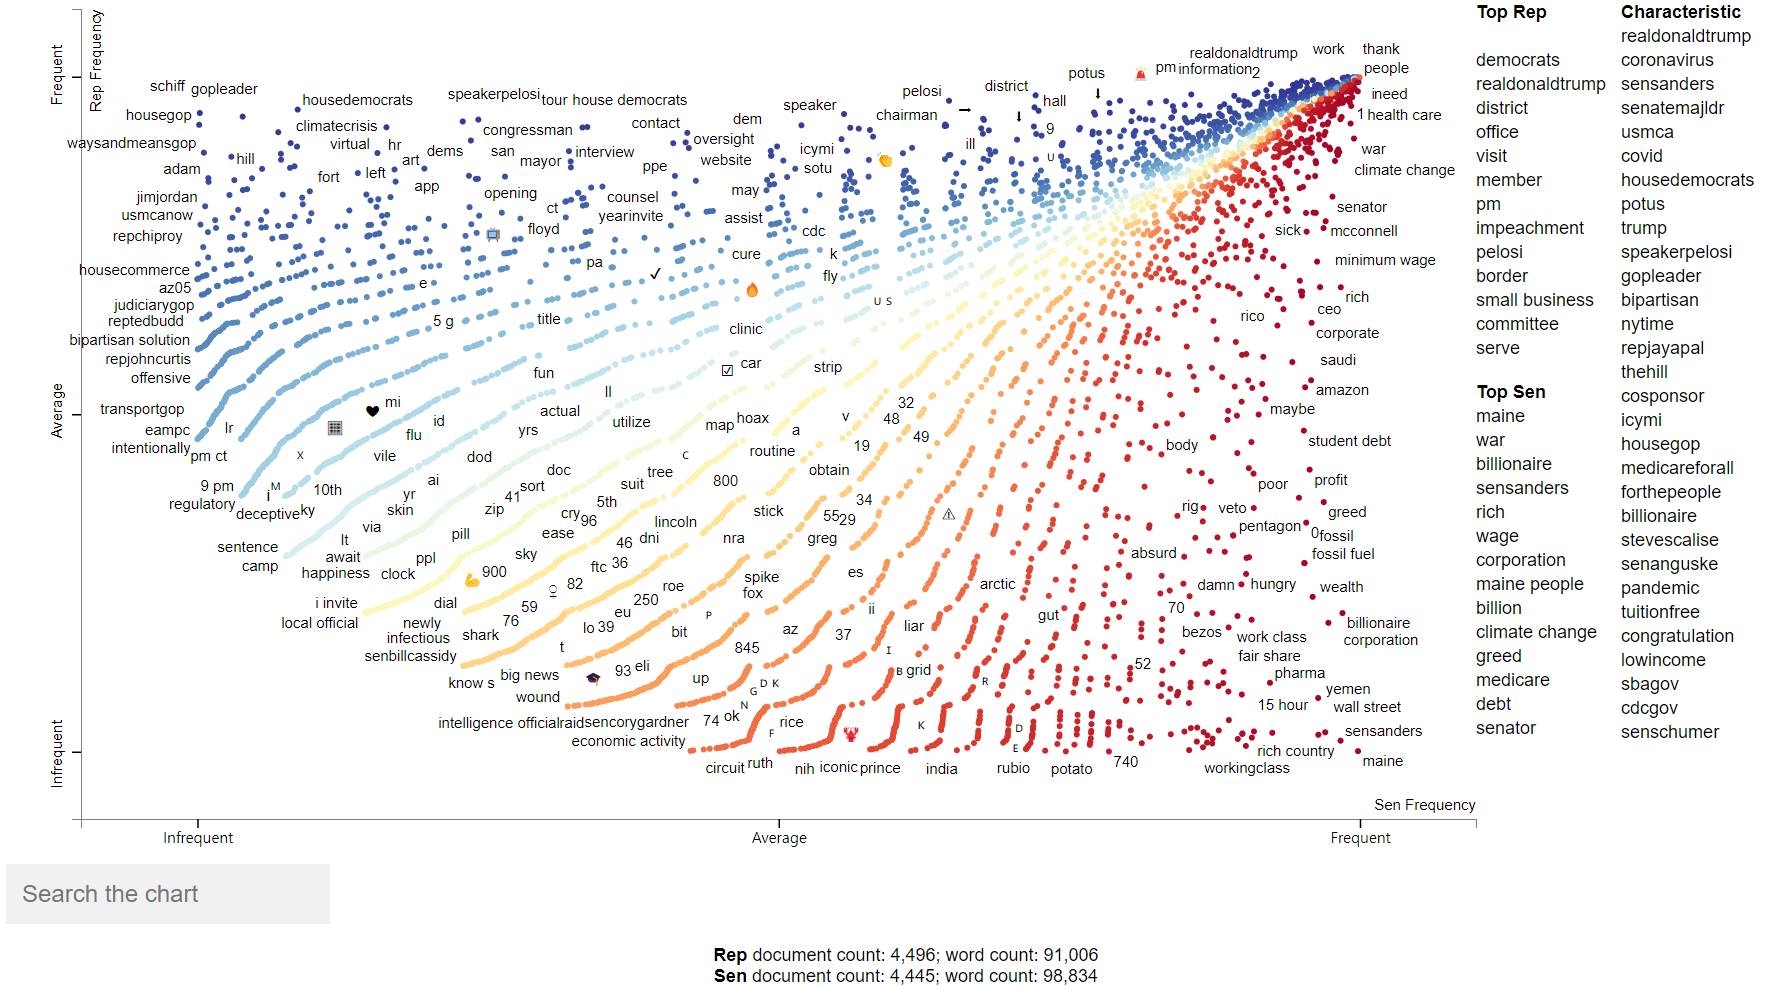

### 3. Word Frequencies

In [ ]:
###' ################################################################################
###'
###' VISUALIZATION : WORDS COUNT
###' _ unigrams
###'
###'


### most frequent unigrams 
countvec = CountVectorizer(min_df = 5, ngram_range=(1,1))
ngrams = countvec.fit_transform(tweets_party['tokens_join'])      


### create a dataframe 
dictionary_dataframe = pd.DataFrame(ngrams.todense(),
                                    columns = countvec.get_feature_names_out()) 


### organize a dataframe 
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index()


### plot 
sns.barplot(x="ngrams", 
            y = "freq",
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

In [ ]:
###' ################################################################################
###'
###' VISUALIZATION : WORDS COUNT
###' _ bigrams, trigrams
###'
###'


### most frequent bigrams 
countvec = CountVectorizer(min_df = 5, ngram_range=(2,3))


### fit and transform on tokens
ngrams = countvec.fit_transform(tweets_party['tokens_join'])      


### create a dataframe 
dictionary_dataframe = pd.DataFrame(ngrams.todense(),
                                    columns = countvec.get_feature_names_out()) 


### organize a dataframe 
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index(drop = True)


### plot 
sns.barplot(x="ngrams", 
            y = "freq",
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()


###' ############### for classification
ngrams_S = countvec.fit_transform(tweets_party[tweets_party['party'] != 'Independent']['tokens_join'])
dictionary_dataframe_S = pd.DataFrame(ngrams_S.todense(),
                                      columns = countvec.get_feature_names_out()) 

df_ngram_S = pd.DataFrame(dictionary_dataframe_S.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram_S = df_ngram_S.sort_values(by = ['freq'],
                                    ascending = False).reset_index(drop = True)


### top_25_ngrams for classification
top_25_ngrams = dictionary_dataframe_S.loc[:,df_ngram_S[0:25]['ngrams']]
top_25_ngrams.head()

In [ ]:
### most frequent trigrams 
countvec = CountVectorizer(min_df = 5, ngram_range=(3,4))


### fit and transform on tokens
ngrams = countvec.fit_transform(tweets_party['tokens_join'])      


### create a dataframe 
dictionary_dataframe = pd.DataFrame(ngrams.todense(),
                                    columns = countvec.get_feature_names_out()) 


### organize a dataframe 
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index(drop = True)


### plot 
sns.barplot(x="ngrams", 
            y = "freq",
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

### 4. Topic Modeling

In [ ]:
###' ################################################################################
###'
###' Topic Modeling : TD-IDF Matrix
###' by. party
###'
###'


### Republican

### create tf-idf matrix
tfidf = TfidfVectorizer(min_df = 5) 
tfidf_mx_a = tfidf.fit_transform(tweets_party[tweets_party['party'] == 'Republican']['tokens_join'])



### convert matrix to an arrray and then to a dataframe
tfidf_df_a = pd.DataFrame(data = tfidf_mx_a.toarray(),
                        columns = tfidf.get_feature_names_out())

## sort by term frequency on the first document
tfidf_df_a.T.nlargest(10,0)

In [ ]:
### Democrat

### create tf-idf matrix
tfidf = TfidfVectorizer(min_df = 5) 
tfidf_mx_b = tfidf.fit_transform(tweets_party[tweets_party['party'] == 'Democrat']['tokens_join'])



### convert matrix to an arrray and then to a dataframe
tfidf_df_b = pd.DataFrame(data = tfidf_mx_b.toarray(),
                        columns = tfidf.get_feature_names_out())

## sort by term frequency on the first document
tfidf_df_b.T.nlargest(10,0)

In [ ]:
### Independent

### create tf-idf matrix
tfidf = TfidfVectorizer(min_df = 5) 
tfidf_mx_c = tfidf.fit_transform(tweets_party[tweets_party['party'] == 'Independent']['tokens_join'])



### convert matrix to an arrray and then to a dataframe
tfidf_df_c = pd.DataFrame(data = tfidf_mx_c.toarray(),
                        columns = tfidf.get_feature_names_out())

## sort by term frequency on the first document
tfidf_df_c.T.nlargest(10,0)

In [ ]:
###' ################################################################################
###'
###' Topic Modeling : TD-IDF Matrix
###' by. position
###'
###'

### Rep

### create tf-idf matrix
tfidf = TfidfVectorizer(min_df = 5) 
tfidf_mx_d = tfidf.fit_transform(tweets_party[tweets_party['position'] == 'Rep']['tokens_join'])



### convert matrix to an arrray and then to a dataframe
tfidf_df_d = pd.DataFrame(data = tfidf_mx_d.toarray(),
                        columns = tfidf.get_feature_names_out())

## sort by term frequency on the first document
tfidf_df_d.T.nlargest(10,0)

In [ ]:
### Sen

### create tf-idf matrix
tfidf = TfidfVectorizer(min_df = 5) 
tfidf_mx_e = tfidf.fit_transform(tweets_party[tweets_party['position'] == 'Sen']['tokens_join'])


### convert matrix to an arrray and then to a dataframe
tfidf_df_e = pd.DataFrame(data = tfidf_mx_e.toarray(),
                        columns = tfidf.get_feature_names_out())

## sort by term frequency on the first document
tfidf_df_e.T.nlargest(10,0)

In [ ]:
### Overall

### create tf-idf matrix
tfidf = TfidfVectorizer(min_df = 5) 
tfidf_mx = tfidf.fit_transform(tweets_party['tokens_join'])


### convert matrix to an arrray and then to a dataframe
tfidf_df = pd.DataFrame(data = tfidf_mx.toarray(),
                        columns = tfidf.get_feature_names_out())


###' ############### for classification
tfidf_mx_S = tfidf.fit_transform(tweets_party[tweets_party['party'] != 'Independent']['tokens_join'])
tfidf_df_S = pd.DataFrame(data = tfidf_mx_S.toarray(),
                          columns = tfidf.get_feature_names_out())

#tfidf_df_S.T.nlargest(10,0)



## sort by term frequency on the first document
tfidf_df.T.nlargest(10,0)

In [ ]:
###' ################################################################################
###'
###' Topic Modeling : Latent Dirichlet Allocation (LDA)
###'
###'


### define function
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nlda_{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    

In [ ]:
### train LDA model
lda = LatentDirichletAllocation(n_components = 5,
                                max_iter = 20,
                                random_state = 224) 
lda.fit(tfidf_mx)

In [ ]:
print_top_words(lda,                             # model 
                tfidf.get_feature_names_out(),   # feature names 
                20)                              # number of top words

In [ ]:
### join
col_names = ['lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4']
topic_dist_lda = pd.DataFrame(lda.transform(tfidf_mx),
                              columns = col_names)

tweets_party = tweets_party.join(topic_dist_lda)


### calculate mean
for i in col_names:
    print(tweets_party.groupby('party')[i].agg('mean'), '\n')

In [ ]:
### print top words 
print_top_words(lda,               
                tf_feature_names,  
                20)    

### join
col_names = ['lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4']
topic_dist_lda = pd.DataFrame(lda.transform(tfidf_mx),
                              columns = col_names)

In [ ]:
### drop Independent party
tweets_party_RD = tweets_party[tweets_party['party'] != 'Independent']


### plot distribution of topic
sns.displot(tweets_party_RD, 
            x=tweets_party_RD['ida_3'],
            hue = 'party',
            common_norm = False,
            kind = 'kde',
            fill = 'true')
plt.show()

In [ ]:
###' ################################################################################
###'
###' Topic Modeling : Non-Negative Matrix Factorization (NMF)
###'
###'


### define function
def print_top_words(model, feature_names, n_top_words): 
    for topic_idx, topic in enumerate(model.components_): 
        print("\nnmf_{}:".format(topic_idx))   
        print(" ".join([feature_names[i]        
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
    
### train NMF model
nmf = NMF(n_components=5,  
          init='random',   
          random_state=1)  

nmf = nmf.fit(tfidf_mx)


### print top words 
print_top_words(nmf, tfidf.get_feature_names_out(),20)  


### join
col_names = ['nmf_0', 'nmf_1', 'nmf_2', 'nmf_3', 'nmf_4']
topic_dist_nmf = pd.DataFrame(nmf.transform(tfidf_mx),
                              columns = col_names)

tweets_party = tweets_party.join(topic_dist_nmf)


### calculate mean
for i in col_names:
    print(tweets_party.groupby('party')[i].agg('mean'), '\n')

In [ ]:
### drop Independent party
tweets_party_RD = tweets_party[tweets_party['party'] != 'Independent']


### plot distribution of topic
sns.displot(tweets_party_RD, 
            x=tweets_party_RD['nmf_0'],
            hue = 'party',
            common_norm = False,
            kind = 'kde',
            fill = 'true')

plt.show()

## PART 4. Featurization

### 1. TF-IDF

In [ ]:
tfidf_df.head(n=10)

## 2.Word Embedding

In [ ]:
###' ################################################################################
###'
###' Word Embedding : Word2VecModel
###'
###'


### drop na
tweets_party = tweets_party[tweets_party['tokens'].notna()]

### Train Word2VecModel
model = gensim.models.Word2Vec(tweets_party['tokens'].tolist(),
                               vector_size = 150, 
                               window = 5, 
                               min_count = 5, 
                               sg = 0, 
                               alpha = 0.025,
                               epochs = 5,
                               seed = 224,
                               batch_words = 10000,
                               workers = 1)

### return list of words
words = list(model.wv.index_to_key)
print(words[0:300]) 

In [ ]:
### trials
print(str(model.wv.most_similar('american')) + '\n' +
      '\n' +
      str(model.wv.most_similar('promise')) + '\n' +
      '\n' +
      str(model.wv.most_similar('election')) + '\n' +
      '\n' +
      '\n' +
      str(model.wv.similarity('good', 'friend')) + '\n' +
      '\n' +
      str(model.wv.similarity('wage', 'tax')) + '\n' +
      '\n' +
      str(model.wv.similarity('crisis', 'live')) + '\n' +
      '\n' +
      '\n' +
      str(model.wv.most_similar(positive=['honor', 'improve'], negative=['hard'])) + '\n' +
      '\n' +
      str(model.wv.most_similar(positive=['realDonaldTrump', 'urge'], negative=['win'])) + '\n' +
      '\n' +
      str(model.wv.most_similar(positive=['king', 'woman'], negative=['man'])) + '\n' +
      '\n' +
      '\n' +
      str(model.wv.doesnt_match("poll counts ElectionDay".split())) + '\n' +
      '\n' +
      str(model.wv.doesnt_match("good friend business".split())) + '\n' +
      '\n' +
      str(model.wv.doesnt_match("american work hard trip breakfast vacation".split())) + '\n')


In [ ]:
###' ################################################################################
###'
###' Word Embedding : Principal Component Analysis (PCA)
###'
###'


### take random sample
rando = random.sample(list(model.wv.index_to_key), 50) 
X1 = model.wv.__getitem__(rando)

### initalize PCA
pca1 = PCA(n_components=2)
result = pca1.fit_transform(X1)

### convert to dataframe 
result_df = pd.DataFrame(result,                  
                         columns = ['PC1', 'PC2'],
                         index = rando)   

### create scatterplot
sns.scatterplot(x = 'PC1',         # specify x-axis
                y = 'PC2',         # specify y-axis
                data = result_df)  # specify data

### initialize empty list
texts = []

### append words to list
for word in result_df.index:
    texts.append(plt.text(result_df.loc[word, 'PC1'], 
                          result_df.loc[word, 'PC2'], 
                          word, 
                          fontsize = 8))
    
### adjust plot text to prevent overlapping 
adjust_text(texts, 
            force_text = (0.4,0.4),
            expand = (1.2,1),
            arrowprops = dict(arrowstyle = "-", 
                              color = 'black', 
                              lw = 0.5))

### plot 
plt.show();

In [ ]:
###' ################################################################################
###'
###' Word Embedding : t-SNE
###'
###'


### preprocessing
vector_list = [model.wv.__getitem__(word) for word in words if word in model.wv.index_to_key]
words_filtered = [word for word in words if word in model.wv.index_to_key]
word_vec_zip = zip(words_filtered, vector_list)


### create a dictionary and save as a dataframe
word_vec_dict = dict(word_vec_zip)
word_vec_df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
word_vec_df.shape


### initialize t-SNE
tsne = TSNE(n_components = 2,  # specify 2 components
            init = 'random',   # set initalization
            random_state = 10, # set seed
            perplexity = 100)  # set preplexity threshold


### subset to only 400 rows to speed up training time
tsne_df = tsne.fit_transform(word_vec_df[:400])


### figure specifications
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(x = tsne_df[:, 0], 
                y = tsne_df[:, 1], 
                alpha = 0.5)


### Convert tsne_df to DataFrame
tsne_df = pd.DataFrame(tsne_df, index=words_filtered[:400], columns=['PC1', 'PC2'])

### Initialize empty list
texts = []

### Append words to list using loop
for word in tsne_df.index:
    texts.append(plt.text(tsne_df.loc[word, 'PC1'], 
                          tsne_df.loc[word, 'PC2'], 
                          word, 
                          fontsize = 8))

### Adjust plot text to prevent overlapping 
adjust_text(texts, 
            force_text = (0.4,0.4),
            expand = (1.2,1),
            arrowprops = dict(arrowstyle = "-", 
                              color = 'black', 
                              lw = 0.5))

plt.show()


### 3. Engineered Text Features

In [ ]:
tweets_party.columns

In [ ]:
### drop independent party for clasification
tweets_party_S = tweets_party[tweets_party['party'] != 'Independent']


### text based features
textF = tweets_party_S[['text_len','word_count', 'polarity', 'subjectivity']]


### text based features + topic
textFT = tweets_party_S[['text_len','word_count', 'polarity', 'subjectivity',
                        'lda_0','lda_1','lda_2','lda_3','lda_4','nmf_0','nmf_1','nmf_2','nmf_3','nmf_4']]


### non-text features
textNF = tweets_party_S[['party', 'position', 'gender', 'state', 'age']]
textNF_dum = pd.get_dummies(textNF).reset_index(drop = True)


### non + text based
textN_F_dum = textF.reset_index(drop = True).join(textNF_dum)


### tf-idf
tfidf_df_S = pd.DataFrame(tfidf_mx_S.todense(),
                          columns = tfidf.get_feature_names_out())


### non-text + tf-idf  
textNF_dum_idf = textNF_dum.reset_index(drop = True).join(tfidf_df_S.drop(columns='age'))


### non-text + 25 ngrams
textNF_dum_ngram = textNF_dum.reset_index(drop = True).join(top_25_ngrams)

## PART 5. Classification

In [ ]:
###' ################################################################################
###'
###' Classification
###' _ pre-processing 
###'
###'


### set dependent Y
lb = LabelBinarizer()

y_party = lb.fit_transform(tweets_party_S['party'])
y_position = lb.fit_transform(tweets_party_S['position'])


### create a list of dataframes
dataframes = [textF, 
              textFT,
              textNF_dum,
              textN_F_dum,
              tfidf_df_S, 
              textNF_dum_idf,
              top_25_ngrams,
              textNF_dum_ngram]


# create a list of labeles based on the objects created above
featurization_technique = ['TextBased',
                           'TextBased + Topic',
                           'NonText',
                           'NonText +TextBased',
                           'tf-idf',
                           'NonText + tf-idf',
                           '25N-Grams',
                           'NonText + 25N-Grams']

In [ ]:
# classification model for Republican=1
# loop over each dataframe, apply a logit classification model, and create a confusion matrix
# ----
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    # split data
    X_train, X_test, Y_train, Y_test = train_test_split(
        dataframe, 
        y_party,
        train_size = .80, 
        test_size = .20, 
        random_state = 224) 
    
    # fit logit model 
    logit = LogisticRegression(max_iter = 500)
    logit.fit(X_train,
              Y_train.ravel())
    
    # create a confusion matrix
    Y_pred = logit.predict(X_test)
    cm = confusion_matrix(Y_test,
                          Y_pred,
                          normalize = "true") 

    # plot
    ConfusionMatrixDisplay(cm).plot()
    plt.title(featurization);

    # print
    print('accuracy score of', featurization, ':', logit.score(X_test, Y_pred))

In [ ]:
# classification model for Republican=1
# loop over each dataframe, apply a logit classification model, and create a confusion matrix
# ----
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    # split data
    X_train, X_test, Y_train, Y_test = train_test_split(
        dataframe, 
        y_position,
        train_size = .80, 
        test_size = .20, 
        random_state = 224) 
    
    # fit logit model 
    logit = LogisticRegression(max_iter = 500)
    logit.fit(X_train,
              Y_train.ravel())
    
    # create a confusion matrix
    Y_pred = logit.predict(X_test)
    cm = confusion_matrix(Y_test,
                          Y_pred,
                          normalize = "true") 

    # plot
    ConfusionMatrixDisplay(cm).plot()
    plt.title(featurization);

    # print
    print('accuracy score of', featurization, ':', logit.score(X_test, Y_test))

### PART 6 : Discussions



**1. Why do standard preprocessing techniques need to be further customized to a particular corpus?**

Standard preprocessing techniques are often customized to a particular corpus because different corpora have unique characteristics. For example, a corpus of tweets may contain slang, abbreviations, and emoticons, which are not typically found in more formal texts. Customizing preprocessing techniques allows for more accurate handling of such unique elements, improving the quality of the data analysis or machine learning model.


**2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?**:

Based on the exploratory analysis, Independents have more positive sentiments than Republicans, and Republicans have more positive sentiments compared to Democrats. Regarding subjectivity, all three parties had similar tendencies. However, this sentiment difference is not clear when comparing Senators and Representatives.


**3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?**

Validating the exploratory and unsupervised learning approaches with a supervised learning algorithm is valuable because it provides a benchmark for performance. Supervised learning algorithms use labeled data, which provides a 'ground truth' that can be used to assess the accuracy of the unsupervised learning model. This validation process helps ensure that the patterns and structures discovered by the unsupervised model are meaningful and not just random noise.


**4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?**

Combining non-text features with TF-IDF and combining non-text features and top 25 ngrams led to the best performance in distinguishing Republican tweets from Democrat tweets. The intuition behind this is that the classification model based on non-text features is improved by the information provided by text data. This combination led to an 100% accuracy score.